In [ ]:
#!pip install ortools


In [ ]:
# from ortools.sat.python import cp_model 
# from ortools.linear_solver import pywraplp
# from __future__ import print_function
# from ortools.sat.python import cp_model
import time
import numpy as np
from pprint import pprint
import random
from random import choices
from copy import deepcopy
from collections import defaultdict
from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
images_dir = '/content/gdrive/My Drive/Negotiation'


Mounted at /content/gdrive


In [ ]:
def create_agents(num_agents, percentage_busy, num_timeslots):
  '''
  creates a dictionary of agents
  each has a unique id, a calendar, and a number of meetings
  num_agents: number of agents to create
  percentage_busy: how many of them should be deemed as busy
  num_timeslots: how many timeslots should their calendar have
  '''

  agents = dict()
  population = [0,1]
  weights = (1-percentage_busy, percentage_busy)
  for i in range(num_agents):
    idx = choices(population,weights)[0]
    
    if idx == 1:
      agents.update({'A%i'%i:{'calendar':{'%i'%i:{'meeting':'No Meeting',
'status':None} for i in range(num_timeslots)},'busy':True, 'num_meetings': 0}})
    
    elif idx == 0:
      agents.update({'A%i'%i:{'calendar':{'%i'%i:{'meeting':'No Meeting',
'status':None} for i in range(num_timeslots)},'busy':False, 'num_meetings': 0}})

  
  return agents

    

In [ ]:
def get_free_slots(dictionary, idx):
  '''
  function that returns free slots for given attendee
  used when populating initial calendar
  '''
  available_slots = []
  for key in dictionary[idx]['calendar'].keys():
    if dictionary[idx]['calendar'][key]['meeting'] == 'No Meeting':
      available_slots.append(key)
  return available_slots


In [ ]:
def get_free_slots_2(m_dict, attendee, num_slots):
  '''
  function that gets free slots for attendee
  adapted for negotiation protocol
  '''
  # slots = []
  # for key in m_dict.keys():
  #   for t in m_dict[key]['timeslots']:
  #     slots.append(t[0])
  

  # available_slots = list(set(slots))

  available_slots =[str(i) for i in  list(range(num_slots))]

  for key in m_dict.keys():
    if attendee in m_dict[key]['attendees']:
      for tuple in m_dict[key]['timeslots']:
        if tuple[0] in available_slots:
          available_slots.remove(tuple[0])

  return available_slots

In [ ]:
def create_meetings(agents, num_slots, density_busy, density_not_busy,
                    min_attendees, max_attendees):
  '''
  function that creates meetings and populates calendars of attendees
  agents: dictionary
  num_slots = number of available slots
  density_busy: How dense should a busy persons calendar be
  density_not_busy: How dense should a not busy persons calendar be
  min, max attendees: minimum and maximum attendees for each meeting
  '''
  #empty dict for meetings:
  meetings = dict()
  count = 0
  #how many meetings busy and non busy individuals should have according to
  #percentages:
  num_meetings_busy = int(num_slots*density_busy)
  num_meetings_not_busy = int(num_slots*density_not_busy)

  #get list of agent ids:
  agent_list = list(agents.keys())
  
  #while the above list is not empty
  while len(agent_list) >= min_attendees:
    #randomly sample a subset of the attendees within allowed number of attendees:
    num = max_attendees
    if len(agent_list) <= num:
      num = len(agent_list)
    attendees = random.sample(agent_list,random.randint(min_attendees,num))


    all_slots = []
    #for each attendee, add the available slots to a list:
    for attendee in attendees:
      available_slots = get_free_slots(agents, attendee)

      #append free slots for a single attendee to array for all attendees
      all_slots.append(available_slots)
    #find the overlap between the slots for each attendee:
    overlap = set(all_slots[0]).intersection(*all_slots)
    #
    if len(overlap) == 0:
      pass
      #print(attendees)
    #if the overlap is a non empty list, choose a random slot
    else:
      meeting_slot = random.choice(list(overlap))
      #create a meeting for that slot, and add it to the meetings dictionary
      meeting_id = 'M%i'%count
      count += 1
      #randomly assign an initiator
      initiator_idx = random.randint(0,len(attendees)-1)
      meetings.update({meeting_id: {'attendees': attendees, 'timeslot':
                                    meeting_slot, 
                                    'initiator': attendees[initiator_idx], 
                                    'status':'CONFIRMED'}})

      
      #for each attendee in that meeting, update the calendar and the meetings count
      for attendee in attendees:
        agents[attendee]['calendar'][meeting_slot]['meeting'] = meeting_id
        agents[attendee]['calendar'][meeting_slot]['status'] = 'CONFIRMED'
        agents[attendee]['num_meetings']+= 1
        
        #if the attendees have reached their maximum allowed limit of meetings,
        #remove them from available attendees
        if  agents[attendee]['busy'] and agents[attendee]['num_meetings'] == num_meetings_busy:
          agent_list.remove(attendee)
        if  not agents[attendee]['busy'] and agents[attendee]['num_meetings'] == num_meetings_not_busy:
          agent_list.remove(attendee)
        

     
  return meetings

In [ ]:
def list_duplicates(seq):
  '''
  function that finds duplicates in a list
  this is implemented for testing reasons
  '''
  tally = defaultdict(list)
  for i,item in enumerate(seq):
      tally[item].append(i)
  return ((key,locs) for key,locs in tally.items() 
                          if len(locs)>1)

In [ ]:


def agents_to_dict(a_dictionary):
  '''
  takes agents dictionary and adjusts it for negotiation protocol
  '''

  a_dict = deepcopy(a_dictionary)
  out = {}
  for key in a_dict.keys():
    out.update({key: []})
    for key_2 in a_dict[key]['calendar'].keys():
      if a_dict[key]['calendar'][key_2]['meeting'] != 'No Meeting':
        out[key].append([a_dict[key]['calendar'][key_2]['meeting'], key_2,
                        a_dict[key]['calendar'][key_2]['status']])
  return out

def meetings_to_dict(m_dictionary):
  '''
  takes meetings dictionary and adjusts it for negotiation protocol
  '''
  m_dict = deepcopy(m_dictionary)
  out = {}
  for key in m_dict.keys():
    out.update({key: {'attendees': m_dict[key]['attendees'],
                      'initiator': m_dict[key]['initiator'],
                      'timeslots': []}})
    
    out[key]['timeslots'].append( [m_dict[key]['timeslot'],
                                   m_dict[key]['status']])
  
  return out





In [ ]:
def check_for_duplicates(timeslots):
  '''
  function that takes in timeslots for every meeting
  and checks whether there is overlap between attendees
  '''
  duplicate_timeslots = []
  for dup in sorted(list_duplicates(timeslots)):
      duplicate_timeslots.append(dup)
  final = []
  for i in duplicate_timeslots:
    attendees_of_duplicates = []
    for key in m.keys():
      if m[key]['timeslot'] == i[0]:
        attendees_of_duplicates.append(m[key]['attendees'])
    final.append(attendees_of_duplicates)
  for f in final:
     overlap = set(f[0]).intersection(*f)
     if len(overlap) != 0:
       return('MISTAKE')
  return 'NO MISTAKE'


In [ ]:
def get_number_from_key(key):
  '''
  helper function to get number in key string
  '''
  l = list(key)
  digits = l[1:]
  new_num = int("".join(digits))
  return new_num


In [ ]:
def check(user):
  '''
  takes a user as an input and
  checks whether actual number of meetings matches up 
  to corresponding entry
  '''
  counter = 0
  for key in new_dict_deepcopy[user]['calendar'].keys():
    if new_dict_deepcopy[user]['calendar'][key] != 'No Meeting':
      counter += 1
  if counter ==  new_dict_deepcopy[user]['num_meetings'] == counter:
    return 'CORRECT'
  else:
    return 'WRONG'




In [ ]:

def get_new_meeting_id(meeting_ids):
  '''
  takes previous ids, returns new id
  '''
  last_id = list(meeting_ids[-1])
  digits = last_id[1:]
  new_num = int("".join(digits))+1
  new_id = last_id[0]+str(new_num)
  return new_id


In [ ]:
def get_meetings_at_t_2(timeslot, m_dict):
  ''' 
  function that returns all meetings
  at timeslot t
  '''
  m_dict_1 = deepcopy(m_dict)
  out = {}
  for key in m_dict_1.keys():
    for tuple in  m_dict_1[key]['timeslots']:
      if tuple[0] == timeslot:
        out.update({key:m_dict_1[key]})
  return out

In [ ]:
def bumping_rule_2(attendee,  meeting_in_calendar,meeting_proposed,
                   a_dict, m_dict):
  '''
  function that takes current meeting and proposed meeting and chooses
  whether to bump or not
  '''
  bump = False
  diff_list_1 = []
  diff_list_2 = []
  sum_1 = 0
  sum_2 = 0
  if attendee not in m_dict[meeting_in_calendar]['attendees']:
    return('Wrong Input')
  for att in m_dict[meeting_in_calendar]['attendees']:
    if att != attendee:
      diff_list_1.append(att)
  for att in m_dict[meeting_proposed]['attendees']:
    if att != attendee:
      diff_list_2.append(att)
  for i in diff_list_1:
    sum_1+=  len(a_dict[i])
  for j in diff_list_2:
    sum_2+=  len(a_dict[j])
  if sum_2 > sum_1:
    bump = True
  if print_on:
    print(attendee, 'deciding whether to bump', meeting_in_calendar, 'for',
          meeting_proposed)
    print('Difficulty of', meeting_in_calendar, ':', sum_1)
    print('Difficulty of', meeting_proposed, ':', sum_2)
  return bump

In [ ]:
def create_new_meeting_random_2(num_attendees, a_dict, m_dict):
  '''
  takes in meeting arguments, and creates a pending meeting
  '''
  meeting_ids = list(m_dict.keys())
  new_id = get_new_meeting_id(meeting_ids)
  agent_list = list(a_dict.keys())
  attendees = random.sample(agent_list,num_attendees)
  idx = random.randint(0, len(attendees)-1)
  initiator = attendees[idx]
  timeslots = get_free_slots_2(m_dict, initiator, 40)
  if len(timeslots) == 0:
    return 'No available timeslots for initiator'
  t_idx = random.randint(0, len(timeslots)-1)
  t = timeslots [t_idx]
  out = {new_id: {'attendees': attendees, 'initiator': initiator,
                  'timeslots':[[t, 'PENDING']] }}
  return out


From this point onwards, the functions correspond to the pseudocode in the paper

In [ ]:
def initiate_2_random(num_attendees, a_dict, m_dict):
  '''
  initiates new meeting randomly, and assigns random initiator
  only takes number of attendees as input
  
  '''
  #create new meeting:
  global round
  round+=1
  if print_on:
    print('--------------------------------------------------')
    print('ROUND:',round)
    print('--------------------------------------------------')
    print('initiated random meeting')

  new_meeting = create_new_meeting_random_2(num_attendees, a_dict, m_dict)

  #print('new meeting:')
  #print(new_meeting)

  #update meetings dictionary with new meeting:
  m_dict.update(new_meeting)
  new_id = list(new_meeting)[0]

  timeslot = new_meeting[new_id]['timeslots'][0][0]
  if print_on:
    print('ID:', new_id)
    print('Proposed timeslot:', timeslot)
    print('initiator:',new_meeting[new_id]['initiator'])
    print('attendees:', new_meeting[new_id]['attendees'])
  #for each attenddee call the next function:
  for attendee in new_meeting[new_id]['attendees']:
    if attendee !=  new_meeting[new_id]['initiator']: 

      receive_propose_2(new_id, attendee, timeslot, a_dict, m_dict)

In [ ]:
def initiate_2(meeting, a_dict, m_dict):
  '''
  initiates meeting negotiation for pre-defined meeeting
  that already has given attendees and initiator
  '''
  global round
  round+=1

  if print_on:
    print('--------------------------------------------------')
    print('ROUND:',round)
    print('--------------------------------------------------')
    print('re-initiate negotiation for meeting', meeting)

  #create new meeting:
  
  initiator = m_dict[meeting]['initiator']
  timeslots = get_free_slots_2(m_dict, initiator, 40)
  if print_on:
    print('available timeslots of initiator:', timeslots)

  if len(timeslots) == 0:
    return 'No available timeslots for initiator'
  t_idx = random.randint(0, len(timeslots)-1)
  t = timeslots[t_idx]
  m_dict[meeting]['timeslots'].append([t, 'PENDING'])

  if print_on:
    print('Proposed timeslot:', t)
    print('Initiator:', initiator)
    print('attendees:', m_dict[meeting]['attendees'])

  #for each attenddee call the next function:
  for attendee in m_dict[meeting]['attendees']:
    #########################
    if attendee != initiator: 
    #########################
      receive_propose_2(meeting, attendee, t, a_dict, m_dict)

In [ ]:
############################################################################
### PROPOSE ################################################################
############################################################################

def receive_propose_2(meeting, attendee, timeslot, a_dict, m_dict):
  '''
  takes meeting id and proposed timeslot and checks 
  for individual availability of given
  '''
  global round
  round+=1
  if print_on:
    print('--------------------------------------------------')
    print('ROUND:',round)
    print('--------------------------------------------------')

  reply = 'PENDING'
 
  meetings_at_t = get_meetings_at_t_2(timeslot, m_dict)


  for key in meetings_at_t.keys():
    #for all the available meetings in the tmeslot (besides the new one)
    if key != meeting:
      #if the current attendee is in any of those meetings:
      if attendee in meetings_at_t[key]['attendees']:
        #print('meeting status', meetings_at_t[key]['status'])
        
        #if the specific meeting is pending, reply impossible:
        for tuple in m_dict[key]['timeslots']:
          if print_on:
            print('Status of timeslot', timeslot, 'of',
                  attendee,'before editing:', tuple[1])
          if tuple[0] == timeslot and tuple[1] == 'PENDING':
            reply =  'IMPOSSIBLE'
        
        #if the meeting is already confirmed check the bumping rule: 
          elif tuple[0] == timeslot and tuple[1] == 'CONFIRMED':

          #if the bumping rule holds, bump current
          # meeting and add pending to new
            if bumping_rule_2(attendee, key, meeting, a_dict, m_dict):

              tuple[1] = 'BUMPED'
              if print_on:
                print(attendee,'bumped', key, 'for',meeting)
              for tuple_2 in m_dict[meeting]['timeslots']:
                if tuple_2[0] == timeslot:
                  tuple_2[1] = 'PENDING'
              reply = 'PENDING'
          
            else:
              if print_on:
                print(attendee,'did not bump', key, 'for', meeting)
              reply = 'IMPOSSIBLE'
          
          #cover the BUMPED case
          elif tuple[0] == timeslot and tuple[1] == 'BUMPED':
            if print_on:
              print(attendee,'has a bumped meeting at that timeslot')
            reply =  'PENDING'

      ### BUMPED case not covered? ###
      #if there is no meeting at that timeslot, reply pending
      else:
        for tuple_2 in m_dict[meeting]['timeslots']:
          if tuple_2[0] == timeslot:
            tuple_2[1] = 'PENDING'


        reply = 'PENDING'

  if print_on:
    print('Attendee', attendee, 'replied',reply)

  receive_reply_2(meeting, timeslot, reply, attendee,  a_dict, m_dict)



In [ ]:
# def receive_propose_2(meeting, attendee, timeslot, a_dict, m_dict):
#   '''
#   takes meeting id and proposed timeslot and checks 
#   for individual availability of given
#   '''
#   global round
#   round+=1
#   if print_on:
#     print('--------------------------------------------------')
#     print('ROUND:',round)
#     print('--------------------------------------------------')


#   other_meetings = []

#   #get meetings at specifc timeslot
#   meetings_at_t = get_meetings_at_t_2(timeslot, m_dict)
#   for key in meetings_at_t.keys():
#     #find meetings other than the current one that are attended by the
#     #attenddee:

#     if key != meeting and attendee in meetings_at_t[key]['attendees']:
#       other_meetings.append(key)

#   #If there are other meetings for this attendee in the timeslot:

#   if len(other_meetings) != 0:
#     if print_on:
#       print('other meetings of', attendee,'at', timeslot, ':')
#       print(other_meetings)

#     for key in other_meetings:

#       #if the specific meeting is pending, reply impossible:
#       for tuple in m_dict[key]['timeslots']:
#         if print_on and tuple[0] ==  timeslot:
#           print('Status of timeslot', timeslot, 'of',
#                 attendee,'before editing:',key,'-',tuple[1])
#         if tuple[0] == timeslot and tuple[1] == 'PENDING':
#           reply =  'IMPOSSIBLE'
      
#       #if the meeting is already confirmed check the bumping rule: 
#         elif tuple[0] == timeslot and tuple[1] == 'CONFIRMED':

#         #if the bumping rule holds, bump current
#         # meeting and add pending to new
#           if bumping_rule_2(attendee, key, meeting, a_dict, m_dict):

#             tuple[1] = 'BUMPED'
#             if print_on:
#               print(attendee,'bumped', key, 'for',meeting)
#             for tuple_2 in m_dict[meeting]['timeslots']:
#               if tuple_2[0] == timeslot:
#                 tuple_2[1] = 'PENDING'
#             reply = 'PENDING'
        
#           else:
#             if print_on:
#               print(attendee,'did not bump', key, 'for', meeting)
#             reply = 'IMPOSSIBLE'
        
#         #cover the BUMPED case
#         else: #if tuple[0] == timeslot and (tuple[1] == 'BUMPED' or tuple[1] == 'IMPOSSIBLE' or tuple[1] == 'POSSIBLE'):
#           if print_on:
#             print(attendee,'has a', tuple[1], 'meeting at that timeslot')
#           reply =  'PENDING'

#   ### BUMPED case not covered? ###
#   #if there is no meeting at that timeslot, reply pending
#   else:
#     if print_on:
#       print(attendee,'has no other meetings at', timeslot)
#     for tuple_2 in m_dict[meeting]['timeslots']:
#       if tuple_2[0] == timeslot:
#         tuple_2[1] = 'PENDING'


#     reply = 'PENDING'
  
#   if print_on:
#     print('Attendee', attendee, 'replied',reply)
#   receive_reply_2(meeting, timeslot, reply, attendee,  a_dict, m_dict)

In [ ]:
 def receive_reply_2(meeting, timeslot, reply, attendee, a_dict, m_dict):

  '''
  function that takes the replies of attendees for proposed meeting
  and checks for possible intersection.
  If not new timeslot is proposed
  '''
  global round
  round+=1

  reply_list = []
  a_dict[attendee].append([meeting, timeslot, reply])

  if print_on:
    print('--------------------------------------------------')
    print('ROUND:',round)
    print('--------------------------------------------------')
    print('initiator',m_dict[meeting]['initiator'],
          'received reply from', attendee )
  
  for attendee in m_dict[meeting]['attendees']:
    ############################################
    if attendee != m_dict[meeting]['initiator']:
      ##########################################
      for tuple in a_dict[attendee]:
        if tuple[0] == meeting and tuple[1] == timeslot:
          reply_list.append(tuple[2])
    
  #print(reply_list)
  ##########################################################
  if len(reply_list) == len(m_dict[meeting]['attendees'])-1:
  ##########################################################
    if print_on:
      print('All attendees have replied')
      print()
    
    t_list = []
    s_list = []

    for attendee in m_dict[meeting]['attendees']:
      if attendee != m_dict[meeting]['initiator']:

        for tuple in a_dict[attendee]:
          if tuple[0] == meeting and tuple[1] == timeslot:
            t_list.append(tuple)
            s_list.append(tuple[2])
    if print_on:
      print('collected replies list:')
      print()
      print(s_list)
      print()
    
    if len(set(s_list)) == 1 and s_list[0] == 'PENDING':
      
      t_dash = t_list[0][1]
      if print_on:
        print('confirmed timeslot:', t_dash, 'for', meeting)
      
      for tuple in m_dict[meeting]['timeslots']:
        if tuple[0] == t_dash:

          tuple[1] = 'CONFIRMED'
          resolved_2(meeting, a_dict, m_dict)

          if print_on:
            print('attendees of', meeting, m_dict[meeting]['attendees'])
          
          for attendee in m_dict[meeting]['attendees']:
            ###########################################
            if attendee != m_dict[meeting]['initiator']:
              if print_on:
                print('send confirm to attendee', attendee)
                print()
              receive_confirm_2(meeting, t_dash, attendee, a_dict, m_dict)
            ###########################################
            
            
          
          for key in m_dict.keys():

            for tuple_2 in m_dict[key]['timeslots']:
              if tuple_2[0] == t_dash and tuple_2[1] == 'BUMPED':
                if print_on:
                  print('reschedule ',key)
                #return 'Reschedule'
                ##################################################
                reschedule_2(key, m_dict[key]['initiator'], a_dict, m_dict)
                ##################################################
      
    else:

      free_slots = get_free_slots_2(m_dict, m_dict[meeting]['initiator'], 40)
      if print_on:
        print('Remaining free slots of initiator:',free_slots)
      #if no free slot is found send fail
      if len(free_slots) == 0:
        global fail
        fail += 1
        #print('null')
        
        #############################################
        resolved_2(meeting, a_dict, m_dict)
        for attendee in m_dict[meeting]['attendees']:
          if attendee != m_dict[meeting]['initiator']:
            receive_fail_2(meeting, attendee, a_dict, m_dict)
            if print_on:
              print('send meeting', meeting, 'FAILED to', attendee)
        #############################################

      
      else:

        #find new timeslot
        t_idx = random.randint(0, len(free_slots)-1)
        t_dash_dash = free_slots[t_idx]
        
        if print_on:
          print('alternative timeslot for', meeting, ':', t_dash_dash)

        for key in m_dict.keys():

          if key == meeting:
            m_dict[key]['timeslots'].append([t_dash_dash, 'PENDING'])

            for attendee in m_dict[key]['attendees']:
              if attendee != m_dict[meeting]['initiator']:

                #propose alternative timeslot to attendees
                if print_on:
                  print('propose alternative slot to', attendee)
                receive_propose_2(meeting, attendee,
                                  t_dash_dash, a_dict, m_dict)
              
             
    
  else:
    pass
                                              








In [ ]:
def receive_confirm_2(meeting, timeslot, attendee, a_dict, m_dict):
  '''
  function for changing status of confirmed meeting
  '''
  global round
  round+=1

  if print_on:
    print('--------------------------------------------------')
    print('ROUND:',round)
    print('--------------------------------------------------')  
    print(attendee, 'receiving confirmation for', meeting)
  
  for tuple in m_dict[meeting]['timeslots']:
    if tuple[0] == timeslot:
      tuple[1] = 'CONFIRMED'
      resolved_2(meeting, a_dict, m_dict)
  
  for key in m_dict.keys():
    for tuple_2 in m_dict[key]['timeslots']:
      if tuple_2[0] == timeslot and tuple_2[1] == 'BUMPED':
        #print('Im in confirm and will reschedule:', key)
        reschedule_2(key, attendee, a_dict, m_dict)

In [ ]:
def receive_fail_2(meeting, attendee, a_dict, m_dict):
  
  global round
  round+=1


  if print_on:
    print('--------------------------------------------------')
    print('ROUND:',round)
    print('--------------------------------------------------')
    
    print('attendee', attendee, 'received fail for', meeting)
  resolved_2(meeting, a_dict, m_dict)

In [ ]:
def receive_reschedule_2(meeting, attendee, a_dict, m_dict):
  
  global round
  round+=1
  if print_on:
    print('--------------------------------------------------')
    print('ROUND:',round)
    print('--------------------------------------------------') 
    print(attendee, 'received reschedule')
  reschedule_2(meeting, attendee, a_dict, m_dict)

In [ ]:
def reschedule_2(meeting, attendee, a_dict, m_dict):
  '''
  function that reschedules meeting
  '''
  global round
  round+=1

  if print_on:
    print('--------------------------------------------------')
    print('ROUND:',round)
    print('--------------------------------------------------')

    print('rescheduling', meeting)
  
  initiator = m_dict[meeting]['initiator']
  attendees = m_dict[meeting]['attendees']
  
  if initiator == attendee:
    if print_on:
      print(attendee, 'is the initiator')
    for tuple in m_dict[meeting]['timeslots']: ### was key
      if tuple[1] == 'BUMPED' or tuple[1] == 'CONFIRMED':
        if print_on:
          print('Changing the status of', meeting, 'at', tuple[0], 'from',
                tuple[1], 'to IMPOSSIBLE')
        tuple[1] = 'IMPOSSIBLE'

    
    for attendee in m_dict[meeting]['attendees']:
      if attendee != m_dict[meeting]['initiator']:

        for tuple_2 in a_dict[attendee]:
          if tuple_2[2] == 'IMPOSSIBLE' or tuple_2[2] == 'PENDING':
            tuple_2[2] = 'POSSIBLE'
    
    initiate_2(meeting, a_dict, m_dict)
  
  else:
    receive_reschedule_2(meeting, initiator, a_dict, m_dict)



In [ ]:
def resolved_2(meeting, a_dict, m_dict):
  '''
  final function that resolves meetings that
  are either confirmed or failed
  '''
  global round
  round+=1

  if print_on:
    print('--------------------------------------------------')
    print('ROUND:',round)
    print('--------------------------------------------------')

    print('resolving', meeting)

  for key in m_dict.keys():
    if key == meeting:
      for tuple in m_dict[meeting]['timeslots']:
        if tuple[1] == 'PENDING':
          slot = tuple[0]
          tuple[1] = 'POSSIBLE'
          if print_on:
            print('changed status of', meeting,
                  'at', slot, 'from PENDING to POSSIBLE')

          for key in m_dict.keys():
            for tuple_2 in m_dict[key]['timeslots']:
              if tuple_2[0] == slot and tuple_2[1] == 'BUMPED':
                tuple_2[1] = 'CONFIRMED'
                
                if print_on:
                  print('changed status of', meeting, 'at',
                        slot, 'from BUMPED to CONFIRMED')
        


In [ ]:

def get_confirmed_meetings_at_t(timeslot, m_dict):
  ''' 
  function that returns all meetings
  at timeslot t
  '''
  m_dict_1 = deepcopy(m_dict)
  out = {}
  for key in m_dict_1.keys():
    for tuple in  m_dict_1[key]['timeslots']:
      if tuple[0] == timeslot and tuple[1] == 'CONFIRMED':
        out.update({key:m_dict_1[key]})
  return out



In [ ]:

num_steps = 1000
meeting_duration = 1
min_attendees_per_meeting = 2
num_workdays = 5
len_workday = 8
num_agents = 10
num_timeslots = num_workdays*(len_workday//meeting_duration)

all_agents = create_agents(num_agents,0.5,num_timeslots)
new_dict_deepcopy = deepcopy(all_agents)
m = create_meetings(new_dict_deepcopy,num_timeslots,0.8,0.3,2,num_agents)
a_list = list(range(2,num_agents))

round_list = []
fail_list = []
print_on = False

for i in a_list:
  round_step = 0
  fail_step = 0
  for _ in range(num_steps):
    #create the meetings dictionary
    meetings = meetings_to_dict(m)
    meetings_before = deepcopy(meetings)
    agents = agents_to_dict(new_dict_deepcopy)

    # #Get the timeslots for all the meetings:
    # timeslots = []
    # for key in m.keys():
    #   timeslots.append(m[key]['timeslot'])
    # check_for_duplicates(timeslots)


    round = 0
    fail = 0
    initiate_2_random(i, agents, meetings)
    if print_on:
      print()
      print('--------------------------------------------------')
      print('--------------------------------------------------')
      print()
      print('PROCESS HAS ENDED')
      print('TOTAL ROUNDS OF NEGOTIATION:',round)
      print()
      print('--------------------------------------------------')
      print('--------------------------------------------------')
    round_step+=round
    fail_step+=fail
  
  #print(round_step/num_steps)
  round_list.append(round_step/num_steps)
  fail_list.append(fail_step/num_steps)






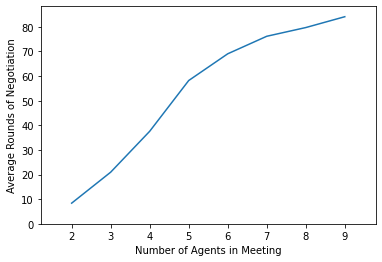

In [ ]:
plt.figure()
plt.plot(a_list, round_list)
plt.xlabel('Number of Agents in Meeting')
plt.ylabel('Average Rounds of Negotiation')
plt.bar(a_list, fail_list)
plt.plot()
plt.savefig(f"{images_dir}/a1_{num_steps}.png")
plt.show()

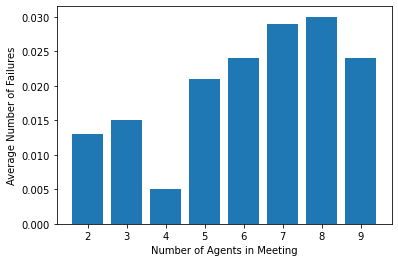

In [ ]:
# Create bars
plt.figure()
plt.bar(a_list, fail_list)
plt.xlabel('Number of Agents in Meeting')
plt.ylabel('Average Number of Failures')
plt.plot()
plt.savefig(f"{images_dir}/b1_{num_steps}.png")
plt.show()

In [ ]:
fail_list

[0.013, 0.015, 0.005, 0.021, 0.024, 0.029, 0.03, 0.024]

In [ ]:

meeting_duration = 1
min_attendees_per_meeting = 2
num_workdays = 5
len_workday = 8
num_agents = 10
num_timeslots = num_workdays*(len_workday//meeting_duration)


p_list = [(i/10,i/10) for i in range(1,9)]
round_list = []
fail_list = []
print_on = False

for i in p_list:
  all_agents = create_agents(num_agents,0.5,num_timeslots)
  new_dict_deepcopy = deepcopy(all_agents)
  m = create_meetings(new_dict_deepcopy,num_timeslots,i[1],i[0],2,num_agents)
  round_step = 0
  fail_step = 0
  for _ in range(num_steps):
    #create the meetings dictionary
    meetings = meetings_to_dict(m)
    meetings_before = deepcopy(meetings)
    agents = agents_to_dict(new_dict_deepcopy)

    # #Get the timeslots for all the meetings:
    # timeslots = []
    # for key in m.keys():
    #   timeslots.append(m[key]['timeslot'])
    # check_for_duplicates(timeslots)


    round = 0
    fail = 0
    initiate_2_random(3, agents, meetings)
    if print_on:
      print()
      print('--------------------------------------------------')
      print('--------------------------------------------------')
      print()
      print('PROCESS HAS ENDED')
      print('TOTAL ROUNDS OF NEGOTIATION:',round)
      print()
      print('--------------------------------------------------')
      print('--------------------------------------------------')
    round_step+=round
    fail_step+=fail
  
  #print(round_step/num_steps)
  round_list.append(round_step/num_steps)
  fail_list.append(fail_step/num_steps)



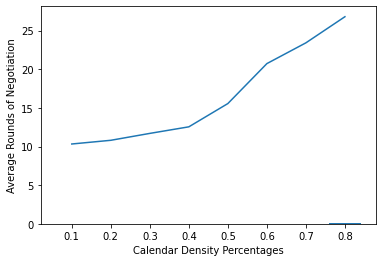

In [ ]:
plt.figure()
x = range(len(p_list))
plt.plot(x, round_list)
plt.xlabel('Calendar Density Percentages')
plt.ylabel('Average Rounds of Negotiation')
plt.bar(x, fail_list)
my_xticks = [i[0] for i in p_list]
plt.xticks(x, my_xticks)
plt.plot()
plt.savefig(f"{images_dir}/c1_{num_steps}.png")
plt.show()



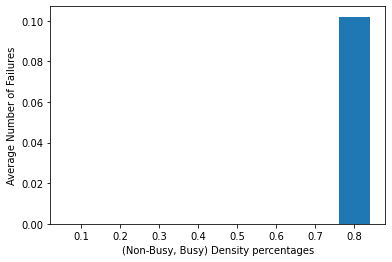

In [ ]:
plt.figure()
plt.bar(x, fail_list)
plt.xlabel('(Non-Busy, Busy) Density percentages')
plt.xticks(x, my_xticks)
plt.ylabel('Average Number of Failures')
plt.plot()
plt.savefig(f"{images_dir}/d1_{num_steps}.png")
plt.show()